# The Product Size Recommendation Problem in N - Dimensions

Bocconi Final Work Triennale Thesis

Note on Anonymization of following Code: This code has been anonymized to comply with regulations in Bocconi Guides to the University - 10.Final Paper amd Graduation section 10.3. Format Specifications - stating that in the content of the final paper, no personal reference of the student can be included (Name, Student ID Number). However, despite its anonymization, all work belongs to the author of Bocconi Thesis titled "The Product Size Recommendation Problem in N - Dimensions".

# Introduction

As provided with the intuition in both the Latent Factor Model and Bayesian Model settings demonstrated by Amazon Research teams, the product size recommendation problem can be extended to N-Dimensions. I attempt to extend the product size recommendation problem to N-Dimensions using the Latent Factor model intuition, namely using machine learning and specifically stochastic gradient descent. 

# Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json

# Read ModCloth json data 

In [32]:
#Insert author name in place of "###########" to run code and load data. Author name was removed for anonymization purposes
#to comply with Bocconi Thesis guidelines as stated above.

df = pd.read_json("/Users/###########/Desktop/Thesis/Code/Datasets/modcloth_final_data.json", lines=True)
df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

Looking at the first 5 rows of the ModCloth data using the method df.head() above, some column names have an underscore in place of the space while others do not. For consistency in column names, we add underscores in place of all spaces. As the size is ModCloth's own size, I also change the size column name to mc_size.

In [33]:
df.columns = ['item_id', 'waist', 'mc_size', 'quality', 'cup_size', 'hips', 'bra_size', 'category', 
                   'bust', 'height', 'user_name', 'length', 'fit', 'user_id', 'shoe_size', 'shoe_width', 
                   'review_summary', 'review_test']

We look at (1) the total number of observations and (2) the datatype in each column.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   mc_size         82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup_size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra_size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe_size       27915 non-null  float64
 15  shoe_width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_test     76065 non-null 

It's clear the data contains a lot of missing values. Some particular variables of interest such as waist have an extremely small percentage of non-missing values. The cell below contains the total number of missing values and the percentage of missing values for each column.

In [35]:
missing_data_sum = df.isnull().sum()
missing_data = pd.DataFrame({'total_missing_values': missing_data_sum,
                             'percentage_of_missing_values': (missing_data_sum/df.shape[0])*100})
missing_data

,total_missing_values,percentage_of_missing_values
item_id,0,0.000000
waist,79908,96.518903
mc_size,0,0.000000
quality,68,0.082136
cup_size,6255,7.555260
hips,26726,32.281677
bra_size,6018,7.268994
category,0,0.000000
bust,70936,85.681846
height,1107,1.337118


Only 6 out of the 18 columns contain complete data. The column "Waist" has 96.5% of values missing.

We check Data Types for numerical and categorical data.

In [36]:
df.dtypes

item_id             int64
waist             float64
mc_size             int64
quality           float64
cup_size           object
hips              float64
bra_size          float64
category           object
bust               object
height             object
user_name          object
length             object
fit                object
user_id             int64
shoe_size         float64
shoe_width         object
review_summary     object
review_test        object
dtype: object

There are some misclassifications of data. Some numeric data is classified as an "Object" type and thus we must handle this type of misclassification. Examples of misclassified data are the bust data and height data, which are clearly numeric but are classified as object.

We check for any unique observations in the columns to see if there is any unique data in any feature.

In [37]:
df.nunique()

item_id            1378
waist                31
mc_size              29
quality               5
cup_size             12
hips                 31
bra_size             11
category              7
bust                 40
height               41
user_name         32429
length                5
fit                   3
user_id           47958
shoe_size            15
shoe_width            3
review_summary    61713
review_test       73313
dtype: int64

There are no unique data for any feature.

# Preliminary Data Visualization

We look at some bar charts for columns with less uniqueness. These columns are quality, cup_size, bra_size, category, length, fit, shoe_size, shoe_width, height, bust, mc_size.

In [38]:
#For cleanliness, we ignore the warnings the matplotlib gives. 
#These warnings have been checked beforehand.
import warnings
warnings.filterwarnings("ignore")

In [39]:
def countplot(indipendent_features):
  plt.figure(figsize=(25, 25))
  for loc, feature in enumerate(indipendent_features):
    ax = plt.subplot(3, 4, loc+1)
    ax.set_xlabel('{}'.format(feature), fontsize=10)
    chart = sns.countplot(df[feature])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
  return None

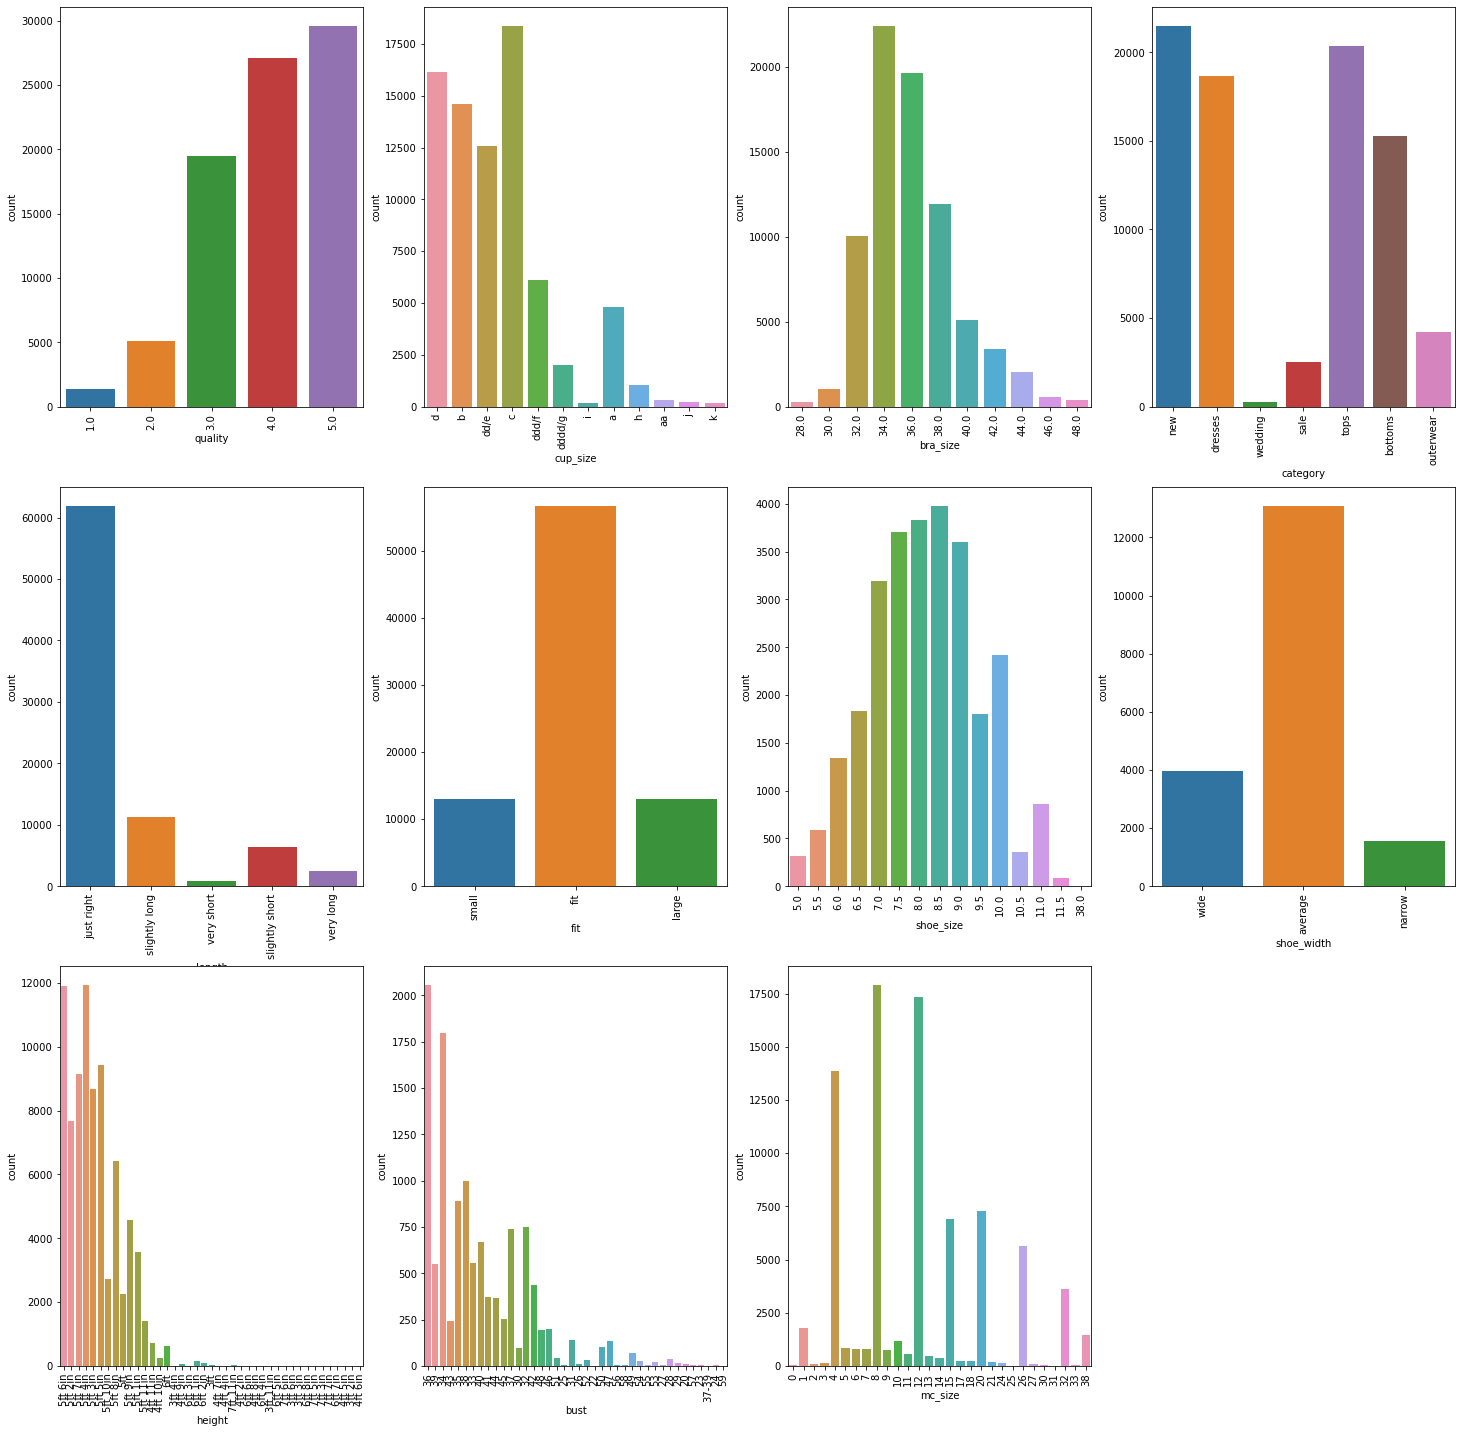

In [40]:
columns_data = ['quality', 'cup_size', 'bra_size', 'category', 'length', 'fit',  'shoe_size', 'shoe_width', 'height', 'bust', 'mc_size']
countplot(columns_data)

Observations of the above bar charts:
- The height column contains many outliers and has a lot of varaince.
- We have categorical data such as shoe_width, category, fit, and height.
- For the bust column, there is one observation with a different type of data. It is labelled "37-39". There is also a lot of variance in bust.
- The shoe_size of 38 is an outlier.

In [41]:
#Replacing the differently labelled bust observation:
df.at[df[df.bust == '37-39'].index[0],'bust'] = '38'

We convert height to a continuous variable by converting feet measurements to centimeters.

# Converting Height variable to centimeters and removing outliers

In [42]:
def height_in_cms(ht):
  if ht.lower() != 'nan':
    ht = ht.replace('ft','').replace('in', '')
    h_ft = int(ht.split()[0])
    if len(ht.split()) > 1:
      h_inch = int(ht.split()[1])
    else:
      h_inch = 0
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    return h_cm

df.height = df.height.astype(str).apply(height_in_cms)
df.head()

,item_id,waist,mc_size,quality,cup_size,hips,bra_size,category,bust,height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_test
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,167.6,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,157.5,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,170.2,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,157.5,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


We deal with the missing values using mean imputation and look into the outliers in the height category using box and scatter plots for visualization.

In [43]:
df.height.fillna(value=df.height.mean(), inplace=True)
df.height.isnull().sum()

0

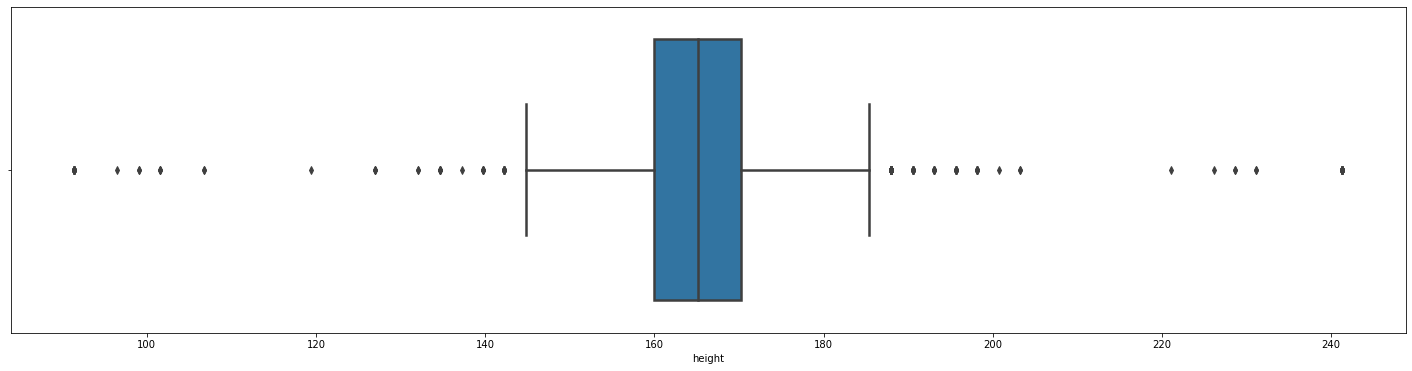

In [44]:
def plot_outlier(feature):
  plt.figure(figsize=(25, 6))
  ax = sns.boxplot(x=feature, linewidth=2.5)
plot_outlier(df.height)

In [45]:
#Checking the lower and upper cutoff values for the outliers.
#That is; lower cutoff value = Q1 - 1.5(IQR)
#upper cutoff value = Q3 + 1.5(IQR)
def get_outliers_range(datacolumn):
  sorted(datacolumn)
  Q1,Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [46]:
ht_lower_range,ht_upper_range = get_outliers_range(df.height)
ht_lower_range,ht_upper_range

(144.70000000000002, 185.49999999999997)

Any data lying below or above the ht_lower_range and ht_upper_range values are considered to be outliers. To get a better idea of the amount of outliers, we count how many outliers exist for the height column.

In [47]:
(df[(df.height < ht_lower_range) | (df.height > ht_upper_range)]).shape

(199, 18)

There are 199 outliers for the height column. This is 0.2% of the observations. We can thus remove these outliers.

In [48]:
df1 = df.drop(df[(df.height < ht_lower_range) | (df.height > ht_upper_range)].index)

df1.reset_index(drop=True, inplace=True)
df1.shape

(82591, 18)

After deleting the observations of height for which we have outliers, we have 82,591 total observations.

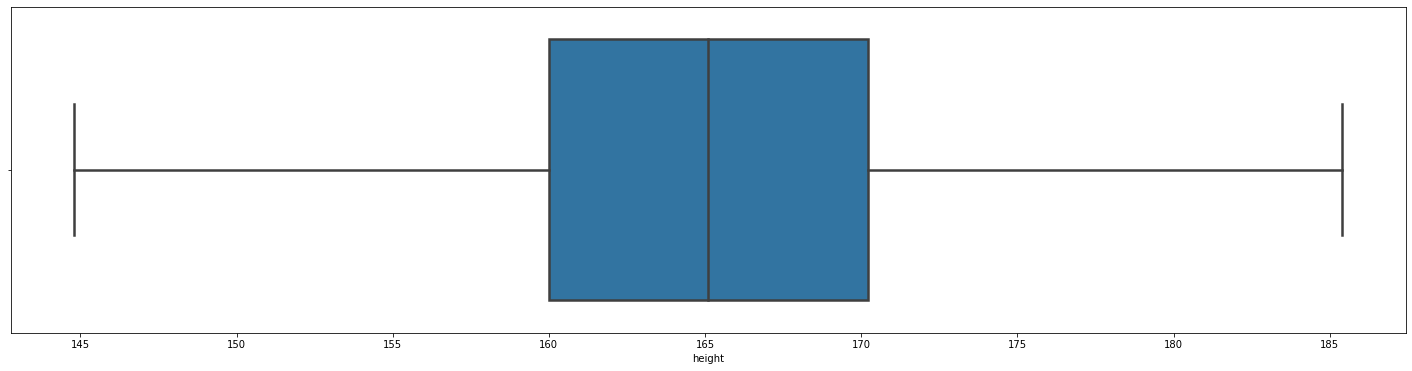

In [49]:
plot_outlier(df1.height)

# Numeric Features Distributions Visualization

In [50]:
def plot_dist(dframe, indipendent_features):
  plt.figure(figsize=(25, 20))
  for loc, feature in enumerate(indipendent_features):
    ax = plt.subplot(3, 3, loc+1)
    sns.distplot(dframe[feature]) # you can try histplot as well
  return None

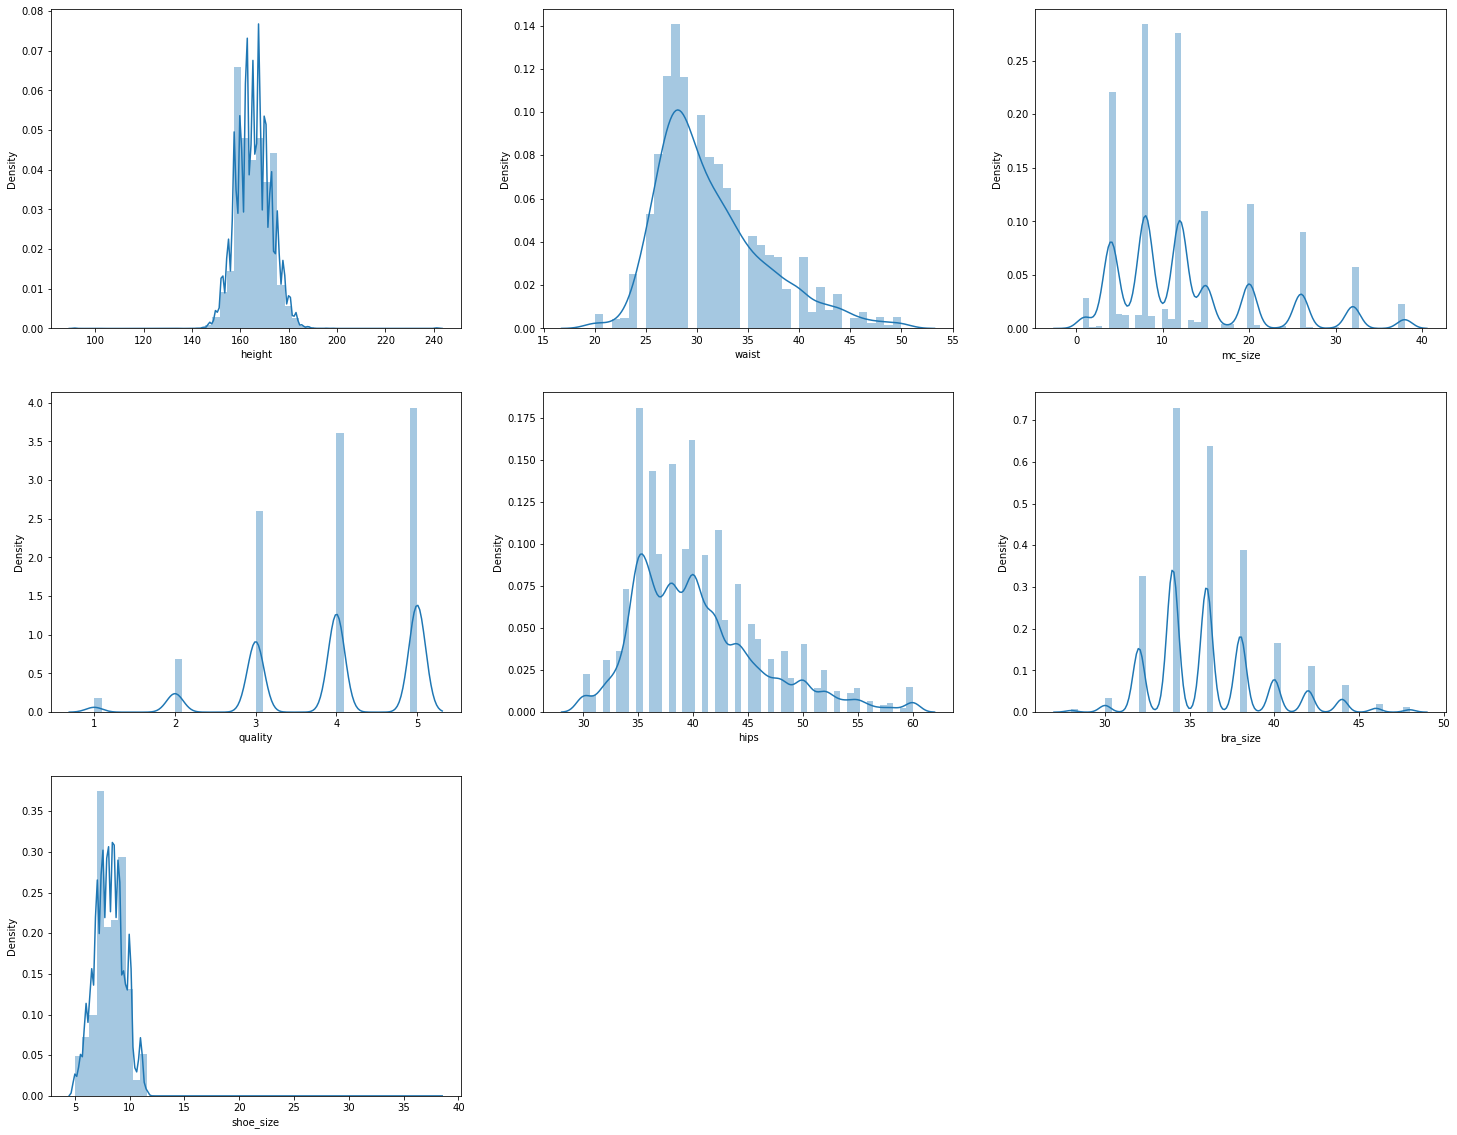

In [51]:
plot_dist(df, ['height', 'waist', 'mc_size', 'quality', 'hips', 'bra_size', 'shoe_size'])

# Handling Missing Values for Numeric Features

As noted above, the data has many missing values. Some vital columns such as waist and bust contain 96.5% and 85.7% of observations as missing values. Because the data is highly sparse, I try to use a K-Nearest-Neighbors (KNN) algorithm to impute the features. This is done using sklearn's KNN Imputer.

In [52]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)

# finding imputation using other features (it will take couple of minutes to complete the execution)
df_knn_ind_features = df1[['waist', 'hips', 'bra_size', 'bust', 'height', 'shoe_size']]

df_filled = imputer.fit_transform(df_knn_ind_features)


knn_numeric_imputations = pd.DataFrame(data=df_filled, columns=['waist', 'hips', 'bra_size', 'bust', 'height', 'shoe_size'])


# remove the existing numeric columns (waist, height, hips, bra_size, bust, shoe_size ) from the main dataframe and concatenate  with knn imputed data
#mc_df = mc_data
new_df = df1.drop(['waist', 'hips', 'bra_size', 'bust', 'height', 'shoe_size'], axis=1)

In [53]:
# I concatenate the imputation data with the mc data frame
mc = pd.concat([new_df, knn_numeric_imputations], axis=1)
mc.isnull().sum()

item_id               0
mc_size               0
quality              68
cup_size           6231
category              0
user_name             0
length               35
fit                   0
user_id               0
shoe_width        64023
review_summary     6710
review_test        6710
waist                 0
hips                  0
bra_size              0
bust                  0
height                0
shoe_size             0
dtype: int64

Now, most of the numeric features have values and the imputation seems to have worked successfully.

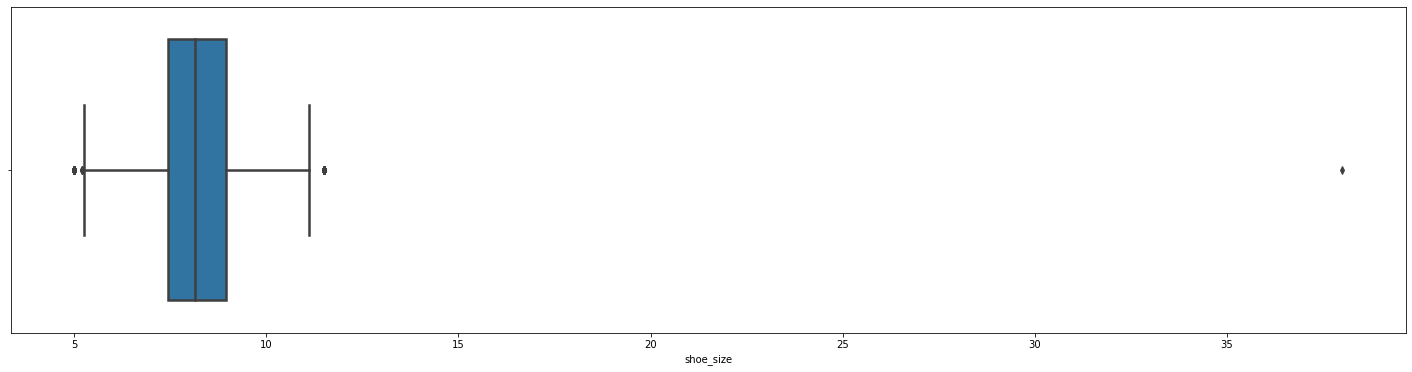

In [54]:
#We deal with the shoe outliers:
plot_outlier(mc.shoe_size)

Again, there are a few outliers. Similarly, as done above, using the IQR cutoff values, we remove outliers lying above Q3 + 1.5(IQR) and below Q1 - 1.5(IQR)

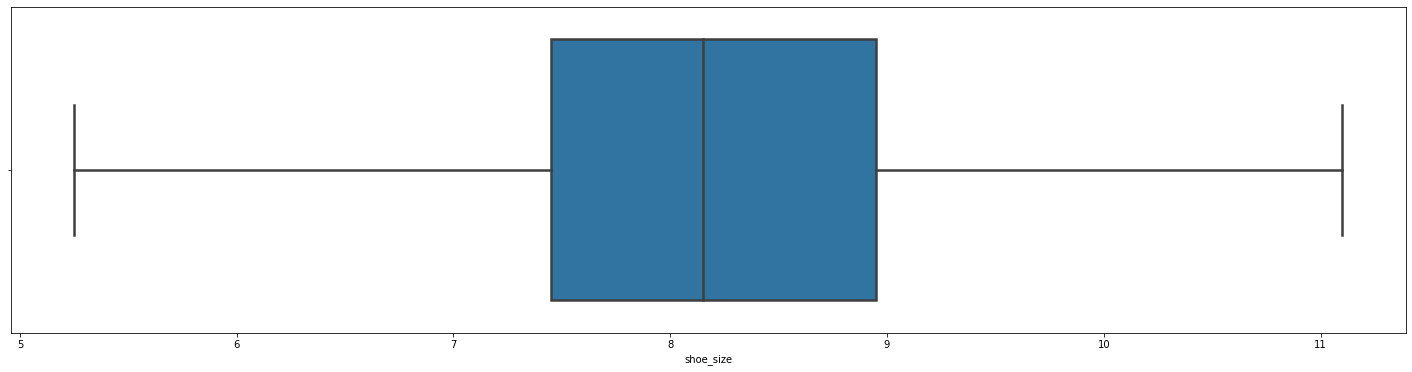

In [55]:
ss_lower_range,ss_upper_range = get_outliers_range(mc.shoe_size)
#print(ss_lower_range,ss_upper_range)

mc.drop(mc[(mc.shoe_size < ss_lower_range) | (mc.shoe_size > ss_upper_range)].index, axis=0, inplace=True) # found 390 observations 
plot_outlier(mc.shoe_size)

# Transforming Categorical Variables to Numeric

Image Source: https://www.blitzresults.com/en/bra-size/

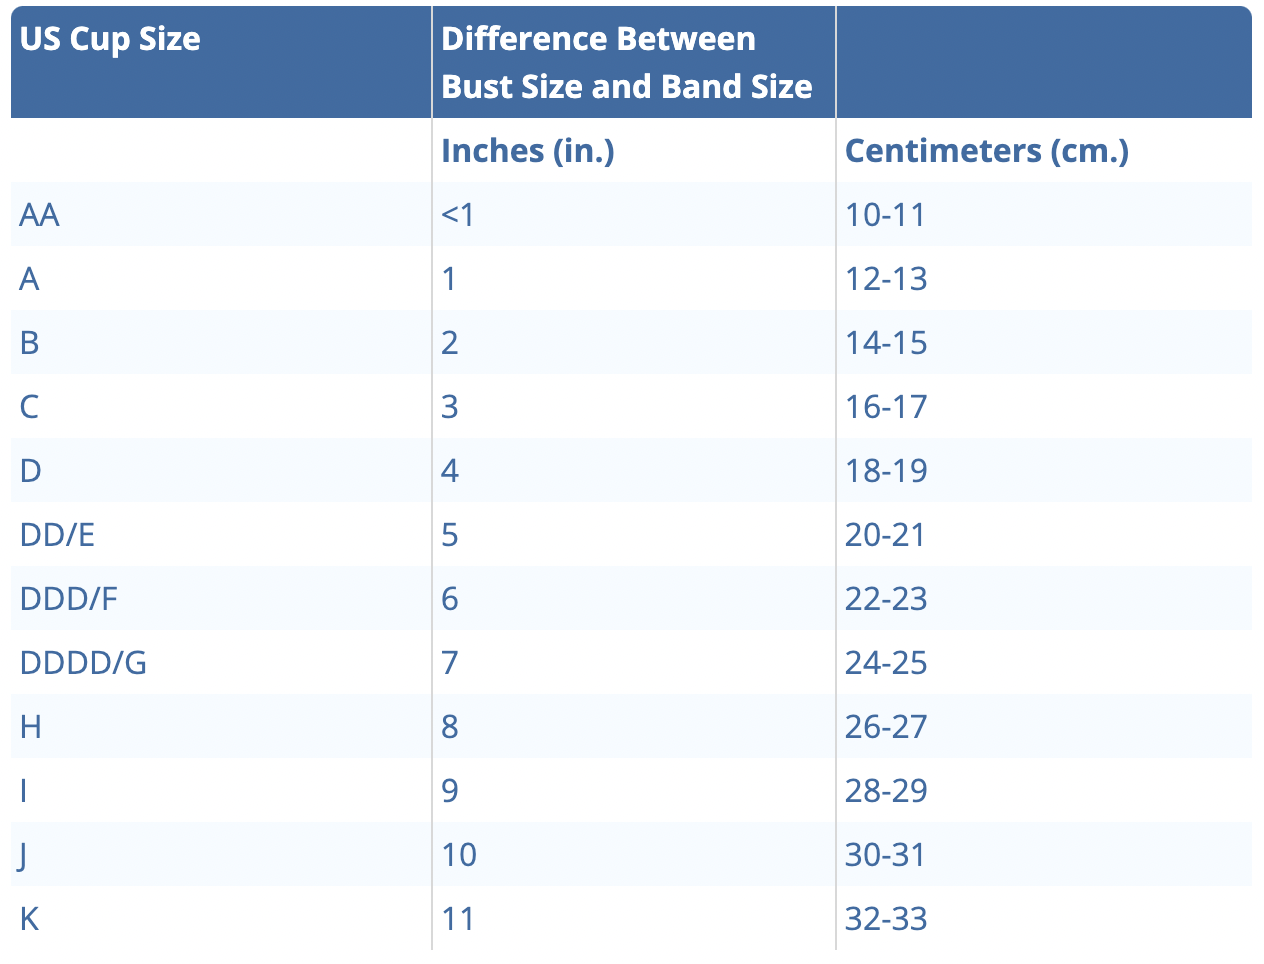

In [56]:
def convert_cup_size_to_cms(cup_size_code):
  if cup_size_code == 'aa':
    return 10, 11
  if cup_size_code == 'a':
    return 12, 13
  if cup_size_code == 'b':
    return 14, 15
  if cup_size_code == 'c':
    return 16, 17
  if cup_size_code == 'd':
    return 18, 19
  if cup_size_code == 'dd/e':
    return 20, 21
  if cup_size_code == 'ddd/f':
    return 22, 23
  if cup_size_code == 'dddd/g':
    return 24, 25
  if cup_size_code == 'h':
    return 26, 27
  if cup_size_code == 'i':
    return 28, 29
  if cup_size_code == 'j':
    return 30, 31
  if cup_size_code == 'k':
    return 32, 33 
  else:
    return str('unknown')

In [57]:
mc['cup_size_in_cms'] = mc.cup_size.apply(convert_cup_size_to_cms)

In [58]:
def split_cup_size_data(data, index):
  if data.lower() == 'unknown':
    return 0
  value = data.replace('(','').replace(')','').replace(',','')
  return value.split()[index]

mc['cup_size_start_in_cms'] =  mc.cup_size_in_cms.astype(str).apply(lambda x : split_cup_size_data(x, 0))
mc['cup_size_end_in_cms'] =  mc.cup_size_in_cms.astype(str).apply(lambda x : split_cup_size_data(x, 1))

In [59]:
mc['cup_size_start_in_cms'] = mc.cup_size_start_in_cms.astype('int')
mc['cup_size_end_in_cms'] = mc.cup_size_end_in_cms.astype('int')


# missing values imputation with mean
mc['cup_size_start_in_cms']  = mc.cup_size_start_in_cms.mask(mc.cup_size_start_in_cms==0).fillna(value=mc.cup_size_start_in_cms.mean())
mc['cup_size_end_in_cms']  = mc.cup_size_end_in_cms.mask(mc.cup_size_end_in_cms==0).fillna(value=mc.cup_size_end_in_cms.mean())

In [60]:
#Check the amount of null values in cup_size
(mc[mc.cup_size.isnull()]).shape

(6218, 21)

We have 6218 null values in cup_size. We drop those rows.

In [61]:
mc = mc.drop(['cup_size', 'cup_size_in_cms'], axis = 1)
mc.reset_index(drop=True,  inplace=True)

# One-Hot Encoding:

We transform several categorical data into numerical data using one-hot encoding:

In [62]:
def countplot_wrt_target(indipendent_features, dframe):
  plt.figure(figsize=(28, 10))
  for loc, feature in enumerate(indipendent_features):
    ax = plt.subplot(1, 3, loc+1)
    ax.set_xlabel('{}'.format(feature), fontsize=10)
    chart = sns.countplot(x=dframe[feature], hue=dframe.fit)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
  return None

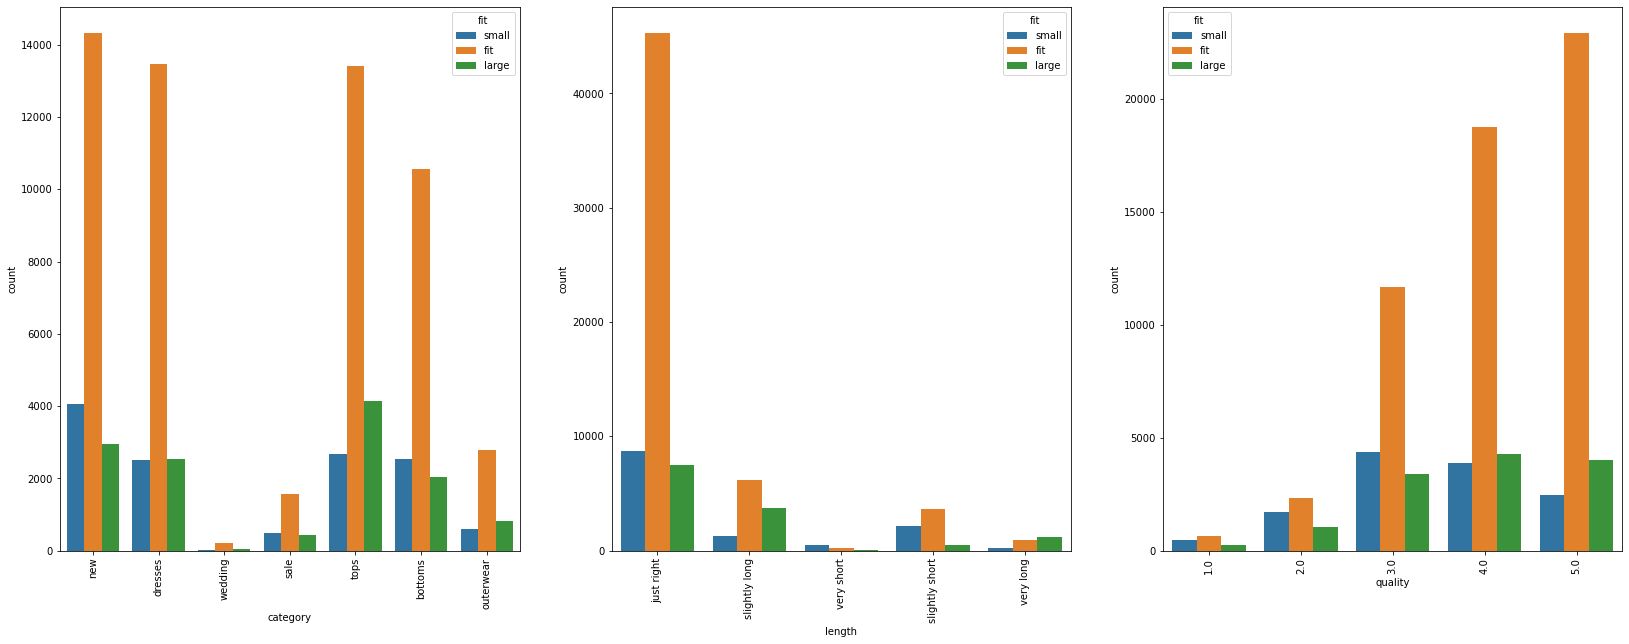

In [63]:
countplot_wrt_target(['category', 'length', 'quality'], mc)

Using the sizing chart, we can identify shoe width based on shoe size. The image can be found in the following link: https://images-na.ssl-images-amazon.com/images/I/71u90X9oX3S.pdf

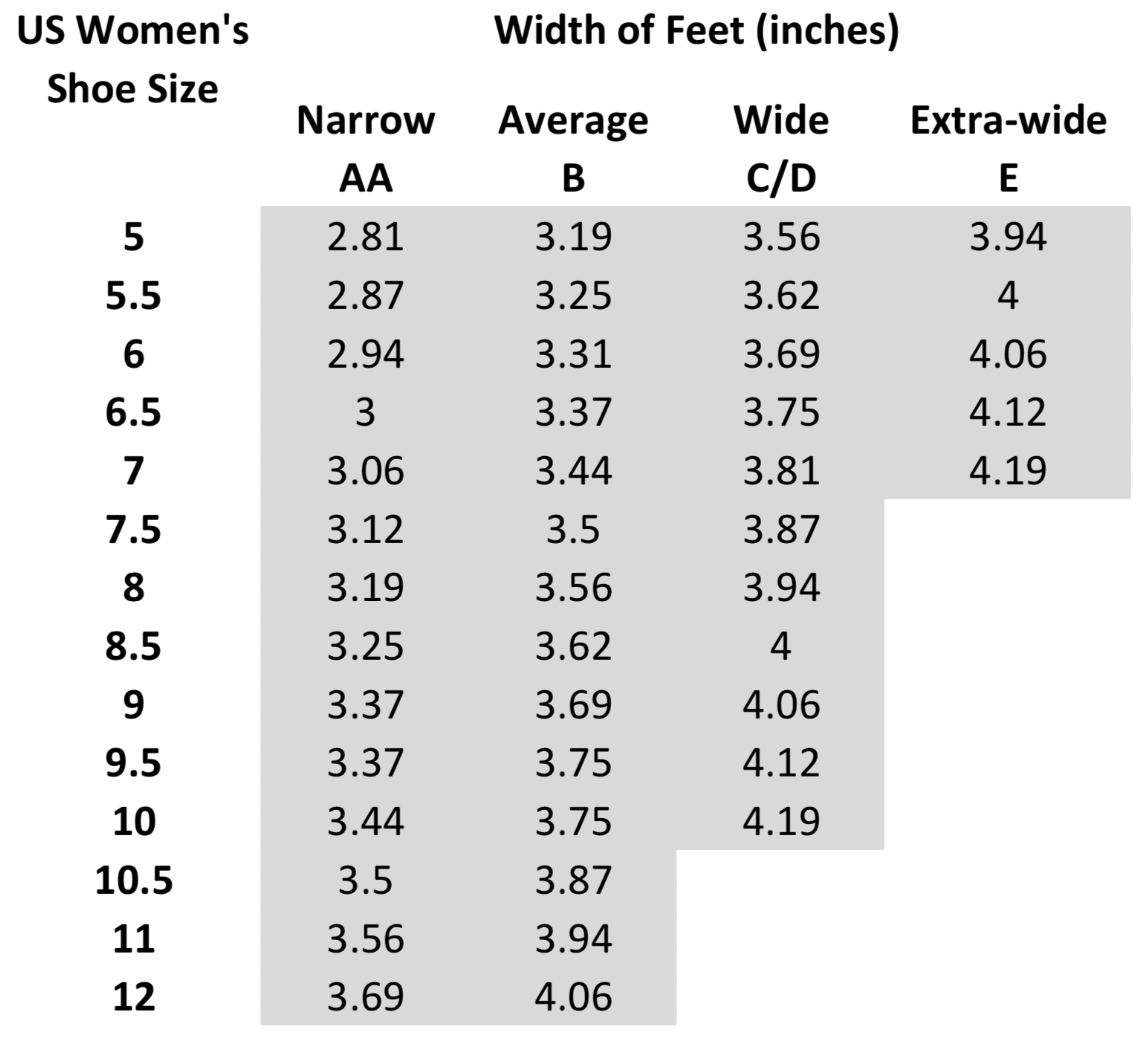

In [64]:
# fill NaN with average shoe width category (this is just an assumption)
mc.shoe_width = mc.shoe_width.fillna('average')

In [65]:
# Use above chart to convert shoe width data such as 'wide','average','narrow' to inches
mc['shoe_width_in_inches'] = np.where(((mc.shoe_size >= 5) & (mc.shoe_size < 5.5)) & (mc.shoe_width == 'narrow') , 2.81, 
np.where(((mc.shoe_size >= 5) & (mc.shoe_size < 5.5)) & (mc.shoe_width == 'average') , 3.19, 
np.where(((mc.shoe_size >= 5) & (mc.shoe_size < 5.5)) & (mc.shoe_width == 'wide') , 3.56,
np.where(((mc.shoe_size >= 5.5) & (mc.shoe_size < 6)) & (mc.shoe_width == 'narrow') , 2.87, 
np.where(((mc.shoe_size >= 5.5) & (mc.shoe_size < 6)) & (mc.shoe_width == 'average') , 3.25, 
np.where(((mc.shoe_size >= 5.5) & (mc.shoe_size < 6)) & (mc.shoe_width == 'wide') , 3.62, 
np.where(((mc.shoe_size >= 6) & (mc.shoe_size < 6.5)) & (mc.shoe_width == 'narrow') , 2.94, 
np.where(((mc.shoe_size >= 6) & (mc.shoe_size < 6.5)) & (mc.shoe_width == 'average') , 3.31, 
np.where(((mc.shoe_size >= 6) & (mc.shoe_size < 6.5)) & (mc.shoe_width == 'wide') , 3.69,
np.where(((mc.shoe_size >= 6.5) & (mc.shoe_size < 7)) & (mc.shoe_width == 'narrow') , 3, 
np.where(((mc.shoe_size >= 6.5) & (mc.shoe_size < 7)) & (mc.shoe_width == 'average') , 3.37, 
np.where(((mc.shoe_size >= 6.5) & (mc.shoe_size < 7)) & (mc.shoe_width == 'wide') , 3.75,
np.where(((mc.shoe_size >= 7) & (mc.shoe_size < 7.5)) & (mc.shoe_width == 'narrow') , 3.06, 
np.where(((mc.shoe_size >= 7) & (mc.shoe_size < 7.5)) & (mc.shoe_width == 'average') , 3.44, 
np.where(((mc.shoe_size >= 7) & (mc.shoe_size < 7.5)) & (mc.shoe_width == 'wide') , 3.81, 
np.where(((mc.shoe_size >= 7.5) & (mc.shoe_size < 8)) & (mc.shoe_width == 'narrow') , 3.12, 
np.where(((mc.shoe_size >= 7.5) & (mc.shoe_size < 8)) & (mc.shoe_width == 'average') , 3.5, 
np.where(((mc.shoe_size >= 7.5) & (mc.shoe_size < 8)) & (mc.shoe_width == 'wide') , 3.87, 
np.where(((mc.shoe_size >= 8) & (mc.shoe_size < 8.5)) & (mc.shoe_width == 'narrow') , 3.19, 
np.where(((mc.shoe_size >= 8) & (mc.shoe_size < 8.5)) & (mc.shoe_width == 'average') , 3.56, 
np.where(((mc.shoe_size >= 8) & (mc.shoe_size < 8.5)) & (mc.shoe_width == 'wide') , 3.94, 
np.where(((mc.shoe_size >= 8.5) & (mc.shoe_size < 9)) & (mc.shoe_width == 'narrow') , 3.25, 
np.where(((mc.shoe_size >= 8.5) & (mc.shoe_size < 9)) & (mc.shoe_width == 'average') , 3.62, 
np.where(((mc.shoe_size >= 8.5) & (mc.shoe_size < 9)) & (mc.shoe_width == 'wide') , 4, 
np.where(((mc.shoe_size >= 9) & (mc.shoe_size < 9.5)) & (mc.shoe_width == 'narrow') , 3.37, 
np.where(((mc.shoe_size >= 9) & (mc.shoe_size < 9.5)) & (mc.shoe_width == 'average') , 3.69, 
np.where(((mc.shoe_size >= 9) & (mc.shoe_size < 9.5)) & (mc.shoe_width == 'wide') , 4.06, 
np.where(((mc.shoe_size >= 9.5) & (mc.shoe_size < 10)) & (mc.shoe_width == 'narrow') , 3.37, 
np.where(((mc.shoe_size >= 9.5) & (mc.shoe_size < 10)) & (mc.shoe_width == 'average') , 3.75, 
np.where(((mc.shoe_size >= 9.5) & (mc.shoe_size < 10)) & (mc.shoe_width == 'wide') , 4.12, 
np.where(((mc.shoe_size >= 10) & (mc.shoe_size < 10.5)) & (mc.shoe_width == 'narrow') , 3.44, 
np.where(((mc.shoe_size >= 10) & (mc.shoe_size < 10.5)) & (mc.shoe_width == 'average') , 3.75, 
np.where(((mc.shoe_size >= 10) & (mc.shoe_size < 10.5)) & (mc.shoe_width == 'wide') , 4.19, 
np.where(((mc.shoe_size >= 10.5) & (mc.shoe_size < 11)) & (mc.shoe_width == 'narrow') , 3.5, 
np.where(((mc.shoe_size >= 10.5) & (mc.shoe_size < 11)) & (mc.shoe_width == 'average') , 3.87, 
np.where(((mc.shoe_size >= 10.5) & (mc.shoe_size < 11)) & (mc.shoe_width == 'wide') , 4.19, 
np.where(((mc.shoe_size >= 11) & (mc.shoe_size < 12)) & (mc.shoe_width == 'narrow') , 3.56, 
np.where(((mc.shoe_size >= 11) & (mc.shoe_size < 12)) & (mc.shoe_width == 'average') , 3.94, 
np.where(((mc.shoe_size >= 11) & (mc.shoe_size < 12)) & (mc.shoe_width == 'wide') , 4.19,
np.nan)))))))))))))))))))))))))))))))))))))))

In [66]:
# drop the refrence colum shoe_width
mc.drop(['shoe_width'], axis=1, inplace=True)

# One-Hot Encoding for Length and Categeory Columns

In [67]:
# replacing NaN values with unknown for the feature length
mc.length = mc.length.fillna('unknown')

In [68]:
length_dummies  = pd.get_dummies(mc['length'])
length_dummies.columns = ['just_right','slightly_long','very_short','slightly_short','very_long', 'length_unknown']

category_dummies  = pd.get_dummies(mc['category'])
category_dummies.columns = ['new','dresses','wedding','sale','tops', 'bottoms','outerwear']

model_df = pd.concat([mc, length_dummies,category_dummies], axis = 1)
model_df.drop(['length'], axis=1, inplace=True)
model_df.drop(['category'], axis=1, inplace=True)

# target variable 
fit = {'small':0, 'fit':1, 'large':2}
model_df['fit'] = model_df['fit'].map(fit)

# Dropping several columns

In [69]:
# We can drop features like item_id , user_id and user_name
model_df.drop(['item_id'], axis=1, inplace=True)
model_df.drop(['user_id'], axis=1, inplace=True)
model_df.drop(['user_name'], axis=1, inplace=True)
model_df.drop(['review_summary'], axis=1, inplace=True)
model_df.drop(['review_test'], axis=1, inplace=True)

# Final Dataframe: model_df

The final data is stored in the dataframe: model_df

In [70]:
model_df.head()

,mc_size,quality,fit,waist,hips,bra_size,bust,height,shoe_size,cup_size_start_in_cms,...,slightly_short,very_long,length_unknown,new,dresses,wedding,sale,tops,bottoms,outerwear
0,7,5.0,0,29.0,38.0,34.0,36.0,167.600000,7.75,18.0,...,0,0,0,0,0,1,0,0,0,0
1,13,3.0,0,31.0,30.0,36.0,37.8,157.500000,7.25,14.0,...,0,0,0,0,0,1,0,0,0,0
2,7,2.0,0,30.0,35.9,32.0,32.9,170.200000,9.00,14.0,...,0,0,0,0,0,1,0,0,0,0
3,21,5.0,1,31.1,41.7,38.6,37.8,165.472612,8.45,20.0,...,0,0,0,0,0,1,0,0,0,0
4,18,5.0,0,31.1,39.2,36.0,37.4,157.500000,7.40,14.0,...,0,0,0,0,0,1,0,0,0,0


# Dataset Statistics

In [71]:
stats_df = mc.copy()
stats_df.drop(['user_name'], axis=1, inplace=True)
stats_df.drop(['review_summary'], axis=1, inplace=True)
stats_df.drop(['review_test'], axis=1, inplace=True)

I create columns C_activity and P_activity to analyze what percentage of users and products are single transactions or multiple. Furthermore, item_id represents the parent product and for completeness, I add a child_id column which is item_id + mc_size.

In [72]:
stats_df["child_id"] = stats_df['item_id'].astype("str") + stats_df["mc_size"].astype("str")

Ctran_Count_s = stats_df['item_id'].notna().groupby(stats_df['user_id']).transform('sum')
stats_df['C_activity'] = Ctran_Count_s.map({0:'Never', 1:'Once'}).fillna('Multiple')

Ptran_Count_s = stats_df['user_id'].notna().groupby(stats_df['child_id']).transform('sum')
stats_df['P_activity'] = Ptran_Count_s.map({0:'Never', 1:'Once'}).fillna('Multiple')

In [73]:
Transactions = stats_df[stats_df.columns[0]].count()
Unique_ID = len(stats_df["user_id"].unique())
Unique_Parents = len(stats_df["item_id"].unique())
Unique_Children = len(stats_df["child_id"].unique())
Fraction_Small = stats_df["fit"].value_counts()["small"]
Fraction_Fit = stats_df["fit"].value_counts()["fit"]
Fraction_Large = stats_df["fit"].value_counts()["large"]
Cust_One_Transaction = stats_df["C_activity"].value_counts()["Once"]
Prod_One_Transaction = stats_df["P_activity"].value_counts()["Once"]

In [76]:
#obtaining interesting statistics ModCloth:
print(f"Transactions: {Transactions}")
print(f"Customers: {Unique_ID}")
print(f"Unique Parents: {Unique_Parents}")
print(f"Unique Children: {Unique_Children}")
print(f"Fraction Small: {Fraction_Small} ({round(Fraction_Small/Transactions,3)*100}%)")
print(f"Fraction Fit: {Fraction_Fit} ({round(Fraction_Fit/Transactions,3)*100}%)")
print(f"Fraction Large: {Fraction_Large} ({round(Fraction_Large/Transactions,3)*100}%)")
print(f"Customers with 1 Transaction: {Cust_One_Transaction} ({round(Cust_One_Transaction/Unique_ID,3)*100}%)")
print(f"Products with 1 Transaction: {Prod_One_Transaction} ({round(Prod_One_Transaction/Unique_Children,3)*100}%)")

Transactions: 82201
Customers: 47636
Unique Parents: 1374
Unique Children: 4980
Fraction Small: 12896 (15.7%)
Fraction Fit: 56339 (68.5%)
Fraction Large: 12966 (15.8%)
Customers with 1 Transaction: 31670 (66.5%)
Products with 1 Transaction: 2019 (40.5%)


We note that the data is extremely sparse. The majority of customers (66.5%) have 1 transaction. A high number of products (40.5%) have 1 transaction.

# Model Creation

In [77]:
model_df.head()

,mc_size,quality,fit,waist,hips,bra_size,bust,height,shoe_size,cup_size_start_in_cms,...,slightly_short,very_long,length_unknown,new,dresses,wedding,sale,tops,bottoms,outerwear
0,7,5.0,0,29.0,38.0,34.0,36.0,167.600000,7.75,18.0,...,0,0,0,0,0,1,0,0,0,0
1,13,3.0,0,31.0,30.0,36.0,37.8,157.500000,7.25,14.0,...,0,0,0,0,0,1,0,0,0,0
2,7,2.0,0,30.0,35.9,32.0,32.9,170.200000,9.00,14.0,...,0,0,0,0,0,1,0,0,0,0
3,21,5.0,1,31.1,41.7,38.6,37.8,165.472612,8.45,20.0,...,0,0,0,0,0,1,0,0,0,0
4,18,5.0,0,31.1,39.2,36.0,37.4,157.500000,7.40,14.0,...,0,0,0,0,0,1,0,0,0,0


# Dresses Category

We find the number of dresses in the dataset and locate them.

In [108]:
print(f"Number of Dresses: {model_df.dresses.value_counts()[1]}")
dresses_df= model_df.loc[model_df['dresses'] == 1]

Number of Dresses: 18501


In [79]:
dresses_df.head()

,mc_size,quality,fit,waist,hips,bra_size,bust,height,shoe_size,cup_size_start_in_cms,...,slightly_short,very_long,length_unknown,new,dresses,wedding,sale,tops,bottoms,outerwear
5305,8,5.0,0,29.0,35.0,34.0,33.6,162.6,8.00,16.0,...,0,0,0,0,1,0,0,0,0,0
5306,8,5.0,1,27.0,35.8,32.0,33.2,170.2,8.50,18.0,...,0,0,0,0,1,0,0,0,0,0
8437,1,5.0,1,26.0,38.0,32.0,33.8,162.6,8.15,12.0,...,0,0,0,0,1,0,0,0,0,0
8438,8,4.0,1,28.6,35.8,34.0,36.5,172.7,8.60,16.0,...,0,0,0,0,1,0,0,0,0,0
8439,8,5.0,1,27.2,37.1,32.0,34.1,157.5,6.70,14.0,...,0,0,0,0,1,0,0,0,0,0


We drop the columns of other categories of clothing as they are now irrelevant. The dresses dataframe is composed of only dresses.

In [80]:
#We drop the columns of categories as they are now irrelevant - They are all dresses.
dresses_df.drop(['new'], axis=1, inplace=True)
dresses_df.drop(['dresses'], axis=1, inplace=True)
dresses_df.drop(['wedding'], axis=1, inplace=True)
dresses_df.drop(['sale'], axis=1, inplace=True)
dresses_df.drop(['tops'], axis=1, inplace=True)
dresses_df.drop(['bottoms'], axis=1, inplace=True)
dresses_df.drop(['outerwear'], axis=1, inplace=True)

# Dress Measurements

The following is a figure of dress measurements taken from the following link: https://www.arabicattire.com/pages/size-guide

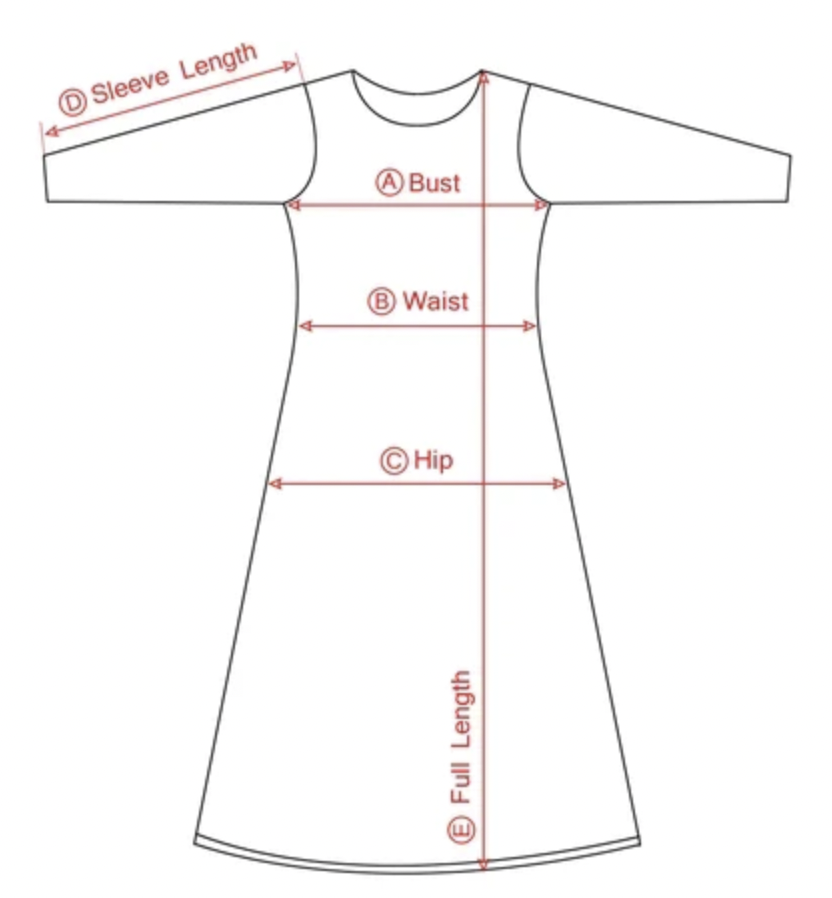

Dress measurements are composed primarily of bust, waist, hip, sleeve length, full length measurements.

In [81]:
dresses_df.columns

Index(['mc_size', 'quality', 'fit', 'waist', 'hips', 'bra_size', 'bust',
       'height', 'shoe_size', 'cup_size_start_in_cms', 'cup_size_end_in_cms',
       'shoe_width_in_inches', 'just_right', 'slightly_long', 'very_short',
       'slightly_short', 'very_long', 'length_unknown'],
      dtype='object')

In [82]:
dresses_df.drop(['quality'], axis=1, inplace=True)
dresses_df.drop(['shoe_size'], axis=1, inplace=True)
dresses_df.drop(['shoe_width_in_inches'], axis=1, inplace=True)
dresses_df.drop(['just_right'], axis=1, inplace=True)
dresses_df.drop(['slightly_long'], axis=1, inplace=True)
dresses_df.drop(['very_short'], axis=1, inplace=True)
dresses_df.drop(['slightly_short'], axis=1, inplace=True)
dresses_df.drop(['very_long'], axis=1, inplace=True)
dresses_df.drop(['length_unknown'], axis=1, inplace=True)

In [83]:
dresses_df.head()

,mc_size,fit,waist,hips,bra_size,bust,height,cup_size_start_in_cms,cup_size_end_in_cms
5305,8,0,29.0,35.0,34.0,33.6,162.6,16.0,17.0
5306,8,1,27.0,35.8,32.0,33.2,170.2,18.0,19.0
8437,1,1,26.0,38.0,32.0,33.8,162.6,12.0,13.0
8438,8,1,28.6,35.8,34.0,36.5,172.7,16.0,17.0
8439,8,1,27.2,37.1,32.0,34.1,157.5,14.0,15.0


# Algorithmic Modelling:

In [85]:
sgdc_df = dresses_df.copy()
sgdc_df.drop(['height'], axis=1, inplace=True)
sgdc_df.drop(['cup_size_start_in_cms'], axis=1, inplace=True)
sgdc_df.drop(['cup_size_end_in_cms'], axis=1, inplace=True)

In [86]:
#Separating the Features and the Labels
x_gd = sgdc_df.drop(columns = ["fit"])
y_gd = sgdc_df["fit"]

In [87]:
from sklearn.model_selection import train_test_split
x_train_gd, x_test_gd, y_train_gd, y_test_gd = train_test_split(x_gd, y_gd, test_size = 0.2, random_state = 42)

In [88]:
from sklearn.linear_model import SGDClassifier
lr_sgd = SGDClassifier(max_iter = 500, random_state = 42)

lr_sgd.fit(x_train_gd, y_train_gd)
lr_sgd_predict = lr_sgd.predict(x_test_gd)

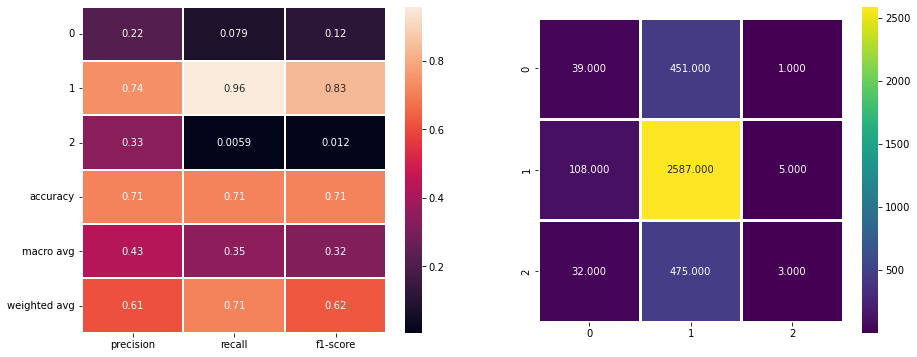

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
clf_report = classification_report(y_test_gd, lr_sgd_predict, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, linewidths=2, annot=True)

ax2 = fig.add_subplot(122)
cm = confusion_matrix(y_test_gd, lr_sgd_predict)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=3, square = True, cmap = 'viridis')
plt.show()

This model uses sklearn's stochastic gradient descent classifier. 

- Accuracy is the ratio of true positives and negatives to all positive and negative observations: Accuracy = TP+TN/(TP+TN+FP+FN)
- Precision measures the proportion of positively predicted labels that are truly correct: Precision = TP/(TP+FP)
- Recall measures the models' ability to correctly predict the positives from actual positives: Recall = TP/(FN+TP)
- F1 score represents the model score as a function of precision and recall score: F1Score = 2 * Precision * Recall/(Precision+Recall) 

The model achieves an accuracy of 0.71. It also achieves Precision, Recall, and F1-Scores of 0.61, 0.71, and 0.62 respectively. Given the limited, sparse data and the shallow learning model used, this is an acceptable result. 

To improve the model, it may be useful to explore model hyperparameters. 

# Algorithm Improvements & Tuning Hyperparameters

The following hyperparameters for scikit learn's Stochastic Gradient Descent classifier can be found on their website:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

It may provide useful to explore the following hyperparametrs and specifically the alpha value.
- Loss: "hinge" (default), "log", "log_loss"
- penalty: {‘l2’, ‘l1’, ‘elasticnet’}, default=’l2’
- alpha: float, default=0.0001
- fit_intercept: Whether the intercept should be estimated or not
- class_weight: dict, {class_label: weight} or “balanced”, default=None

# Random Search and Focused Grid Search

Rather than creating one grid search over the set of all hyperparameters, we first conduct a randomized search over the set of hyperparameters to locate important points of interest. This saves both time and computational power as we do not search futile areas. We then conduct a grid search to exhaustively search the area near the points of interest located by the randomized search.

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Random Search

In [93]:
#Creating the Randomized Search CV
loss = ["hinge", "log", "log_loss"]
penalty = ["l2", "l1"]
alpha = np.linspace(0,0.0002, 11)
fit_intercept = [True, False]

#You can do class weight too. Keep in mind you need to
#create a dictionary with different weights for each value
#for the randomized search. This will take a lot of time.
#It's a potnetial improvement but try just 3 hyperparameters first

random_cv = {'loss': loss,
             'penalty': penalty,
             'alpha': alpha,
             'fit_intercept': fit_intercept
            }

lr_sgd_random = SGDClassifier()
random = RandomizedSearchCV(estimator = lr_sgd_random, param_distributions = random_cv, 
                               n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

random.fit(x_train_gd, y_train_gd)
random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'penalty': 'l2',
 'loss': 'hinge',
 'fit_intercept': False,
 'alpha': 0.00014000000000000001}

From the random search, we have the optimal Penalty is "l2", the optimal loss is "hinge", the optimal fit_intercept is "False", and the optimal alpha is 0.00014000000000000001. We now conduct a grid search to exhaustively search the area around the alpha identified by the random search.

In [102]:
#Creating the Grid Search CV
#With a grid search based on the randomized search result
loss = random.best_params_.get("loss")
penalty = random.best_params_.get("penalty")
alpha = random.best_params_.get("alpha")
fit_intercept = random.best_params_.get("fit_intercept")


param_grid = {
    'loss':[loss],
    'penalty': [penalty],
    'fit_intercept': [fit_intercept],
    'alpha': np.linspace(alpha - 0.00005, alpha + 0.00005, 30)
}


lr_sgd_grid = SGDClassifier()
grid_search = GridSearchCV(estimator = lr_sgd_grid, param_grid = param_grid, 
                           cv = 3, verbose=2, n_jobs = -1)

grid_search.fit(x_train_gd, y_train_gd)
grid_search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'alpha': 0.00014172413793103451,
 'fit_intercept': False,
 'loss': 'hinge',
 'penalty': 'l2'}

The grid search finds the optimal alpha value to be 0.00014172413793103451. 

In [104]:
#Evaluate new models with tuned hyperparameters
#For completion, we also create the model based on the random search parameters

#Random Search Model
lr_sgd_hyp_rand = SGDClassifier(loss = random.best_params_.get("loss"),
                                penalty = random.best_params_.get("penalty"),
                                fit_intercept = random.best_params_.get("fit_intercept"),
                                alpha = random.best_params_.get("alpha"),
                                max_iter = 500, random_state = 42
                               )

lr_sgd_hyp_rand.fit(x_train_gd, y_train_gd)
lr_sgd_hyp_rand_predictions = lr_sgd_hyp_rand.predict(x_test_gd)


#Grid Search Model
lr_sgd_hyp_grid = SGDClassifier(loss = grid_search.best_params_.get("loss"),
                                penalty = grid_search.best_params_.get("penalty"),
                                fit_intercept = grid_search.best_params_.get("fit_intercept"),
                                alpha = grid_search.best_params_.get("alpha"),
                                max_iter = 500, random_state = 42
                               )

lr_sgd_hyp_grid.fit(x_train_gd, y_train_gd)
lr_sgd_hyp_grid_predictions = lr_sgd_hyp_grid.predict(x_test_gd)

# Random Search Confusion Matrix

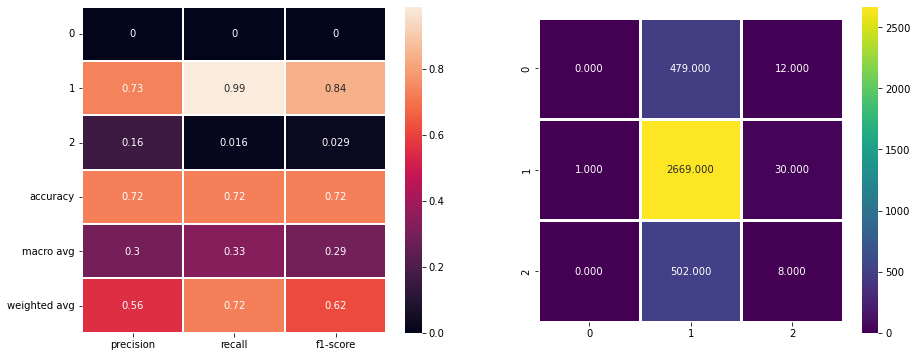

In [106]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
clf_report = classification_report(y_test_gd, lr_sgd_hyp_rand_predictions, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, linewidths=2, annot=True)

ax2 = fig.add_subplot(122)
cm = confusion_matrix(y_test_gd, lr_sgd_hyp_rand_predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=3, square = True, cmap = 'viridis')
plt.show()

# Grid Search Confusion Matrix 

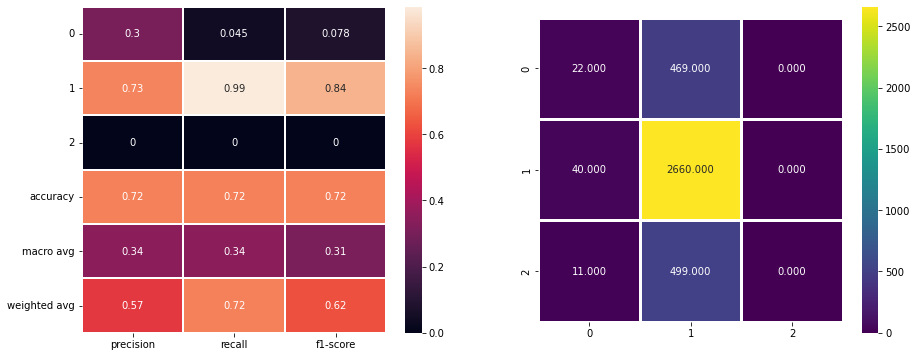

[CV] END alpha=0, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.00010111111111111113, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.5s
[CV] END alpha=0.00013444444444444447, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.0001677777777777778, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00019, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END alpha=9.689655172413795e-05, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END alpha=0.00010034482758620692, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00011413793103448278, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END alpha=0.00011758620689655174, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00012793103448275863, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END

[CV] END alpha=0, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=9.000000000000002e-05, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00012333333333333334, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00015666666666666666, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.0001788888888888889, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END alpha=9.689655172413795e-05, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00010379310344827588, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.3s
[CV] END alpha=0.00011068965517241381, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.00012448275862068968, fit_intercept=False, loss=hinge, penalty=l2; total time=   0.4s
[CV] END alpha=0.0001313793103448276, fit_intercept=False, loss=hinge, penalty=l2; total time=   

In [107]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
clf_report = classification_report(y_test_gd, lr_sgd_hyp_grid_predictions, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, linewidths=2, annot=True)

ax2 = fig.add_subplot(122)
cm = confusion_matrix(y_test_gd, lr_sgd_hyp_grid_predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=3, square = True, cmap = 'viridis')
plt.show()

This model uses sklearn's stochastic gradient descent classifier. 

- Accuracy is the ratio of true positives and negatives to all positive and negative observations: Accuracy = TP+TN/(TP+TN+FP+FN)
- Precision measures the proportion of positively predicted labels that are truly correct: Precision = TP/(TP+FP)
- Recall measures the models' ability to correctly predict the positivies from actual positives: Recall = TP/(FN+TP)
- F1 score represents the model score as a function of precision and recall score: F1Score = 2 * Precision * Recall/(Precision+Recall) 

The grid search model achieves an accuracy of 0.72. This is an improvement from 0.71 in the general model. It also achieves Precision, Recall, and F1-Scores of 0.57, 0.72, and 0.62 respectively. Recall increases by 0.01 and Precision decreases by 0.05 as compared to the original model. The F1-Score remains the same. Again, given the type of data (sparse and limited) and the shallow learning model used, this is overall, an acceptable result.

The model can be improved using a more expansive, full dataset and extensive hyperparameter tuning. This will be touched upon in the "5.11 Inherent Problems and Potential Areas of Improvement" section of the Thesis.